In [6]:
!pip install numpy==2.3.2
!pip install pymc arviz

/tmp/ipython-input-1808186029.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


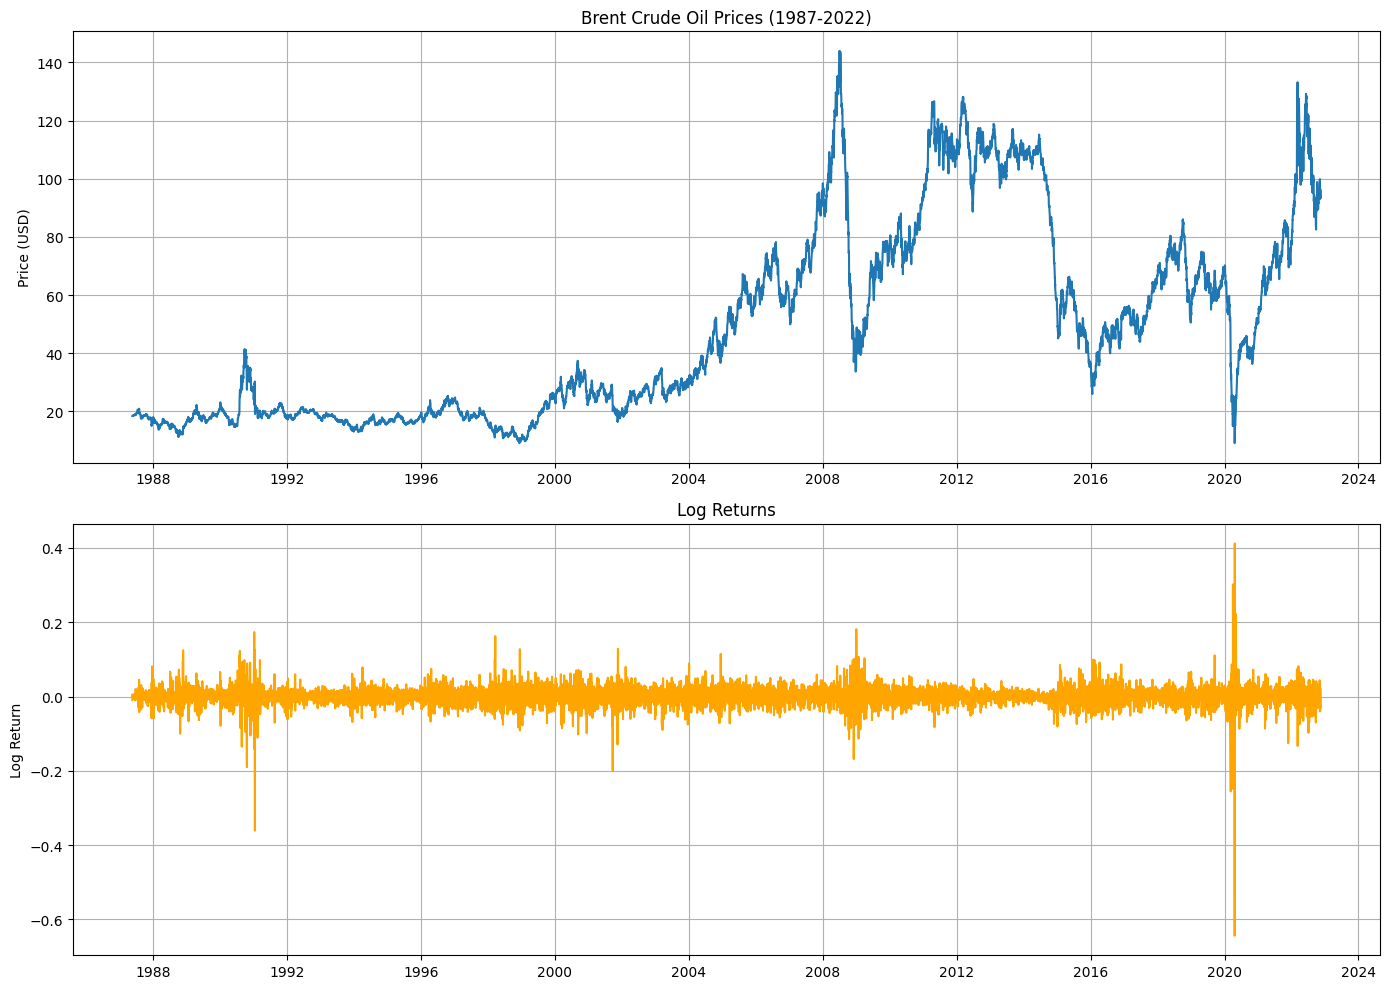

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Load data
df = pd.read_csv("/data/BrentOilPrices.csv")

# Convert Date column to datetime (handling different formats)
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date and reset index
df = df.sort_values('Date').reset_index(drop=True)

# Calculate log returns
df['Log_Price'] = np.log(df['Price'])
df['Log_Return'] = df['Log_Price'].diff()

# Drop NA (first row)
df = df.dropna()

# Plot raw prices and log returns
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Price'])
plt.title('Brent Crude Oil Prices (1987-2022)')
plt.ylabel('Price (USD)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['Log_Return'], color='orange')
plt.title('Log Returns')
plt.ylabel('Log Return')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Prepare data for PyMC3
log_returns = df['Log_Return'].values
dates = df['Date'].values
n_obs = len(log_returns)

# Build the model
with pm.Model() as change_point_model:
    # Uniform prior for the change point
    tau = pm.DiscreteUniform('tau', lower=1, upper=n_obs-1)

    # Priors for pre and post change parameters
    mu1 = pm.Normal('mu1', mu=0, sigma=0.1)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.1)
    sigma1 = pm.HalfNormal('sigma1', sigma=0.1)
    sigma2 = pm.HalfNormal('sigma2', sigma=0.1)

    # Switch between regimes
    mu = pm.math.switch(tau > np.arange(n_obs), mu1, mu2)
    sigma = pm.math.switch(tau > np.arange(n_obs), sigma1, sigma2)

    # Likelihood
    returns = pm.Normal('returns', mu=mu, sigma=sigma, observed=log_returns)

    # Sample from posterior
    trace = pm.sample(3000, tune=2000, chains=2, target_accept=0.9, return_inferencedata=True)

Output()

/usr/local/lib/python3.11/dist-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow 
encountered in dot
  return 0.5 * np.dot(x, v_out)

            mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu1        0.000   0.000    -0.000     0.001      0.000    0.000    6809.0   
mu2       -0.000   0.000    -0.001     0.001      0.000    0.000    7242.0   
sigma1     0.023   0.000     0.023     0.023      0.000    0.000    7316.0   
sigma2     0.029   0.000     0.028     0.030      0.000    0.000    7167.0   
tau     5389.178  20.364  5349.000  5421.000      0.672    0.427     940.0   

        ess_tail  r_hat  
mu1       4393.0   1.00  
mu2       4811.0   1.00  
sigma1    5075.0   1.00  
sigma2    4615.0   1.00  
tau       1391.0   1.01  


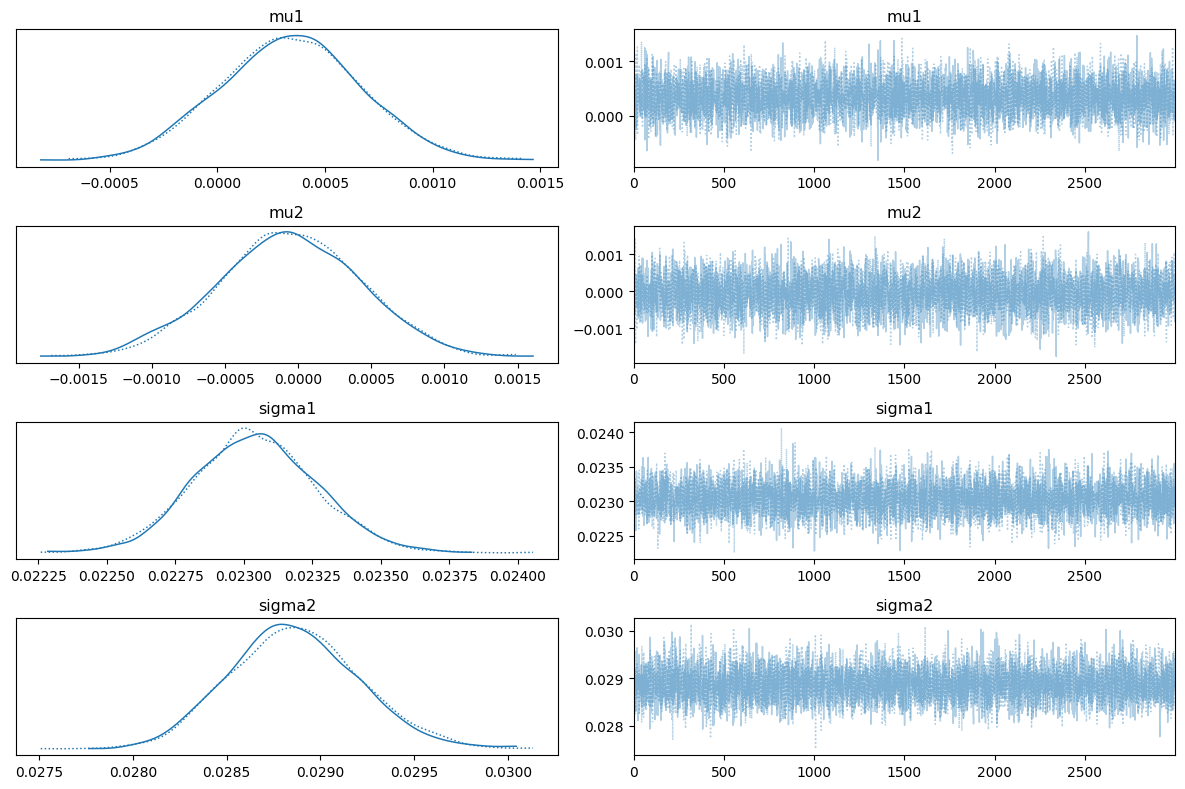

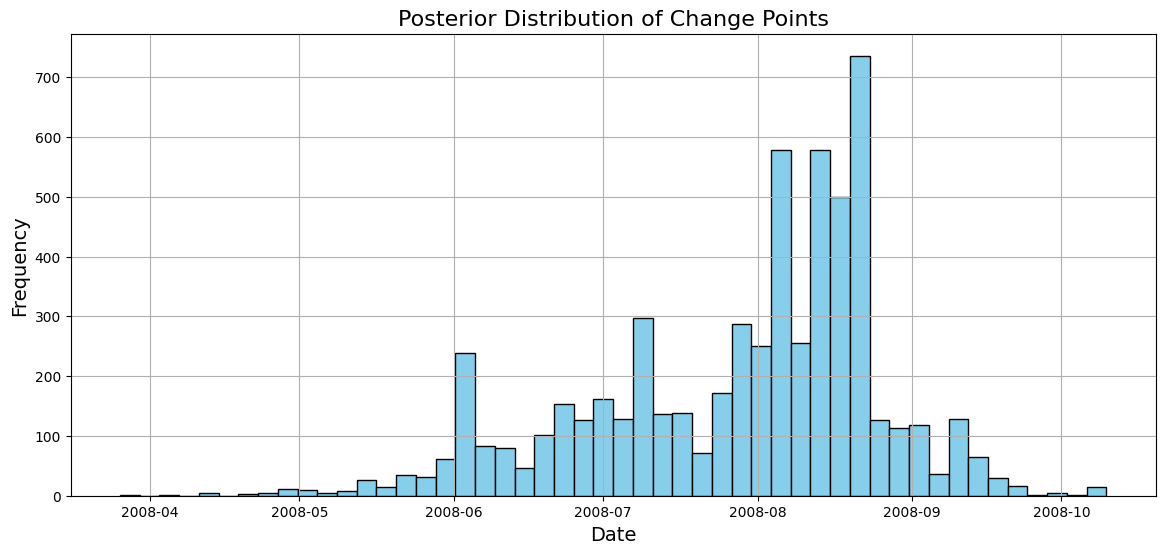


Most probable change point: 2008-08-05T00:00:00.000000000


In [9]:
# Check convergence
print(az.summary(trace, var_names=['mu1', 'mu2', 'sigma1', 'sigma2', 'tau']))

# Plot traces
az.plot_trace(trace, var_names=['mu1', 'mu2', 'sigma1', 'sigma2'])
plt.tight_layout()
plt.show()

# Get posterior samples of tau
tau_samples = trace.posterior['tau'].values.flatten()

# Convert tau indices to dates
change_point_dates = pd.to_datetime([dates[int(tau)] for tau in tau_samples])

# Plot posterior distribution of change points
plt.figure(figsize=(14, 6))
plt.hist(change_point_dates, bins=50, color='skyblue', edgecolor='black')
plt.title('Posterior Distribution of Change Points', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

# Get most probable change point
most_probable_tau = int(np.median(tau_samples))
change_point_date = dates[most_probable_tau]
print(f"\nMost probable change point: {change_point_date}")

In [10]:
# Get parameters before and after change
mu1_post = trace.posterior['mu1'].values.flatten()
mu2_post = trace.posterior['mu2'].values.flatten()
sigma1_post = trace.posterior['sigma1'].values.flatten()
sigma2_post = trace.posterior['sigma2'].values.flatten()

# Calculate price changes (convert from log returns)
avg_price_before = np.exp(np.log(df['Price'].iloc[:most_probable_tau].mean()) + np.mean(mu1_post))
avg_price_after = np.exp(np.log(df['Price'].iloc[most_probable_tau:].mean()) + np.mean(mu2_post))
price_change_pct = (avg_price_after - avg_price_before) / avg_price_before * 100

# Volatility change
volatility_change_pct = (np.mean(sigma2_post) - np.mean(sigma1_post)) / np.mean(sigma1_post) * 100

print(f"\nAverage price before change: ${avg_price_before:.2f}")
print(f"Average price after change: ${avg_price_after:.2f}")
print(f"Price change: {price_change_pct:.1f}%")
print(f"\nVolatility before: {np.mean(sigma1_post):.4f}")
print(f"Volatility after: {np.mean(sigma2_post):.4f}")
print(f"Volatility change: {volatility_change_pct:.1f}%")


Average price before change: $29.81
Average price after change: $76.20
Price change: 155.6%

Volatility before: 0.0230
Volatility after: 0.0289
Volatility change: 25.3%


In [11]:
# Example for 2 change points
with pm.Model() as multi_change_model:
    # Two change points
    tau1 = pm.DiscreteUniform('tau1', lower=1, upper=n_obs-1)
    tau2 = pm.DiscreteUniform('tau2', lower=tau1+1, upper=n_obs-1)

    # Three regimes
    mu = [pm.Normal(f'mu{i}', mu=0, sigma=0.1) for i in range(3)]
    sigma = [pm.HalfNormal(f'sigma{i}', sigma=0.1) for i in range(3)]

    # Regime selection
    regime = pm.math.switch(
        np.arange(n_obs) < tau1,
        0,
        pm.math.switch(np.arange(n_obs) < tau2, 1, 2)
    )
    mu_all = pm.math.switch(regime, mu[0], pm.math.switch(regime, mu[1], mu[2]))
    sigma_all = pm.math.switch(regime, sigma[0], pm.math.switch(regime, sigma[1], sigma[2]))

    # Likelihood
    returns = pm.Normal('returns', mu=mu_all, sigma=sigma_all, observed=log_returns)

    # Sampling
    trace_multi = pm.sample(3000, tune=2000, chains=2, target_accept=0.9)

Output()

/usr/local/lib/python3.11/dist-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow 
encountered in dot
  return 0.5 * np.dot(x, v_out)